# 🚴‍♂️ Анализ данных Divvy Bike Sharing
Этот Jupyter Notebook содержит анализ датасета Divvy Bike Sharing. Здесь представлены:
- Загрузка и предобработка данных
- Визуализация поведения пользователей
- Применение методов снижения размерности: PCA, t-SNE, UMAP
- Кластеризация поездок

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from umap.umap_ import UMAP
from openTSNE import TSNE

from sklearn.preprocessing import StandardScaler

n_jobs = -1
print(f"Будет использовано {os.cpu_count()} логических ядер")

Будет использовано 16 логических ядер


In [32]:
# Загрузка датасета
df = pd.read_csv("../data/trips.csv", encoding="utf_16_le")

df.head()

,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual
0,electric_bike,2024-01-12 15:30:27,2024-01-12 15:37:59,Wells St & Elm St,Kingsbury St & Kinzie St,41.903267,-87.634737,41.889177,-87.638506,member
1,electric_bike,2024-01-08 15:45:46,2024-01-08 15:52:59,Wells St & Elm St,Kingsbury St & Kinzie St,41.902937,-87.634440,41.889177,-87.638506,member
2,electric_bike,2024-01-27 12:27:19,2024-01-27 12:35:19,Wells St & Elm St,Kingsbury St & Kinzie St,41.902951,-87.634470,41.889177,-87.638506,member
3,classic_bike,2024-01-29 16:26:17,2024-01-29 16:56:06,Wells St & Randolph St,Larrabee St & Webster Ave,41.884295,-87.633963,41.921822,-87.644140,member
4,classic_bike,2024-01-31 05:43:23,2024-01-31 06:09:35,Lincoln Ave & Waveland Ave,Kingsbury St & Kinzie St,41.948797,-87.675278,41.889177,-87.638506,member


In [33]:
# Преобразование временных меток
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])

# Добавляем продолжительность поездки в минутах
df['duration'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60

# Фильтруем аномалии (поездки с отрицательной длительностью)
df = df[df['duration'] > 0]

# Извлекаем час и день недели
df['hour'] = df['started_at'].dt.hour
df['day_of_week'] = df['started_at'].dt.dayofweek.map({
    0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'
})

df.head()

,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,duration,hour,day_of_week
0,electric_bike,2024-01-12 15:30:27,2024-01-12 15:37:59,Wells St & Elm St,Kingsbury St & Kinzie St,41.903267,-87.634737,41.889177,-87.638506,member,7.533333,15,Fri
1,electric_bike,2024-01-08 15:45:46,2024-01-08 15:52:59,Wells St & Elm St,Kingsbury St & Kinzie St,41.902937,-87.634440,41.889177,-87.638506,member,7.216667,15,Mon
2,electric_bike,2024-01-27 12:27:19,2024-01-27 12:35:19,Wells St & Elm St,Kingsbury St & Kinzie St,41.902951,-87.634470,41.889177,-87.638506,member,8.000000,12,Sat
3,classic_bike,2024-01-29 16:26:17,2024-01-29 16:56:06,Wells St & Randolph St,Larrabee St & Webster Ave,41.884295,-87.633963,41.921822,-87.644140,member,29.816667,16,Mon
4,classic_bike,2024-01-31 05:43:23,2024-01-31 06:09:35,Lincoln Ave & Waveland Ave,Kingsbury St & Kinzie St,41.948797,-87.675278,41.889177,-87.638506,member,26.200000,5,Wed


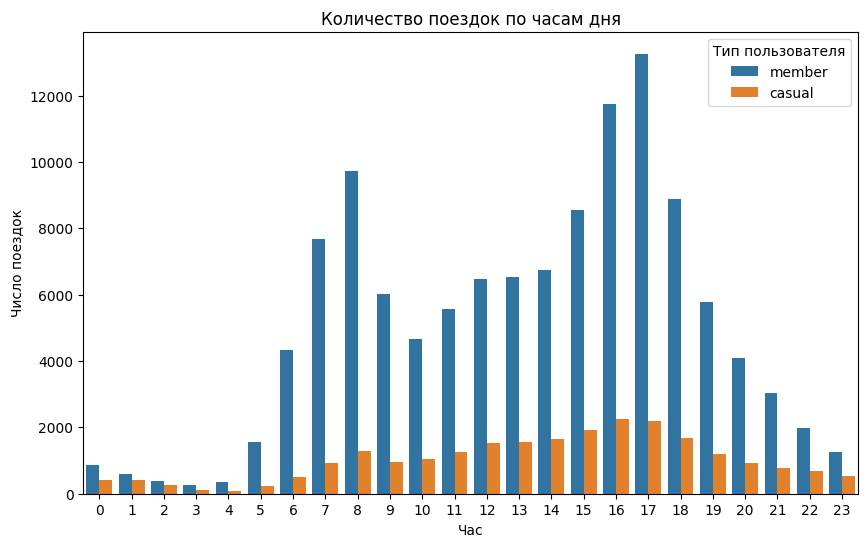

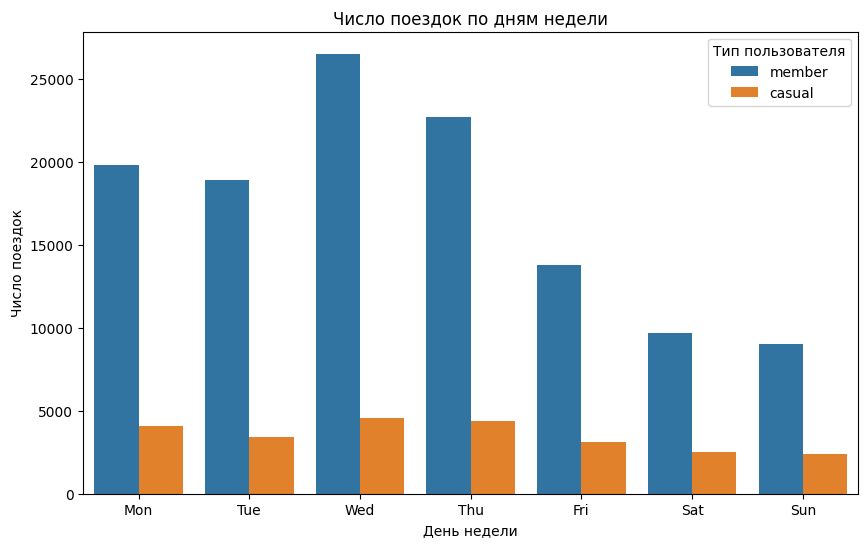

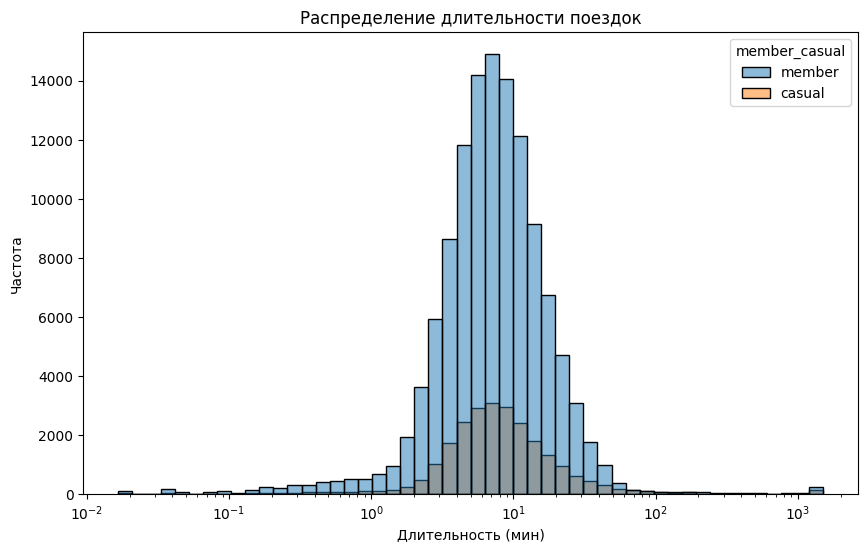

In [34]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='hour', hue='member_casual')
plt.title('Количество поездок по часам дня')
plt.xlabel('Час')
plt.ylabel('Число поездок')
plt.legend(title='Тип пользователя')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='day_of_week', order=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], hue='member_casual')
plt.title('Число поездок по дням недели')
plt.xlabel('День недели')
plt.ylabel('Число поездок')
plt.legend(title='Тип пользователя')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df, x='duration', bins=50, log_scale=True, hue='member_casual', alpha=0.5)
plt.title('Распределение длительности поездок')
plt.xlabel('Длительность (мин)')
plt.ylabel('Частота')
plt.show()

In [35]:
if len(df) < 10_000:
    sample_frac = 1.0
elif len(df) < 50_000:
    sample_frac = 0.3
else:
    sample_frac = 0.1

df_sample = df.sample(frac=sample_frac, random_state=42)
print(f"Используется {int(sample_frac * 100)}% данных для ускорения")

# Подготовка числовых признаков
features = df[['hour', 'day_of_week', 'duration']]
features = pd.get_dummies(features)  # кодируем day_of_week

# Нормализуем
X_scaled = StandardScaler().fit_transform(features)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

Используется 10% данных для ускорения


Используется 10% данных для ускорения


c:\Users\dmitriy.minaev\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


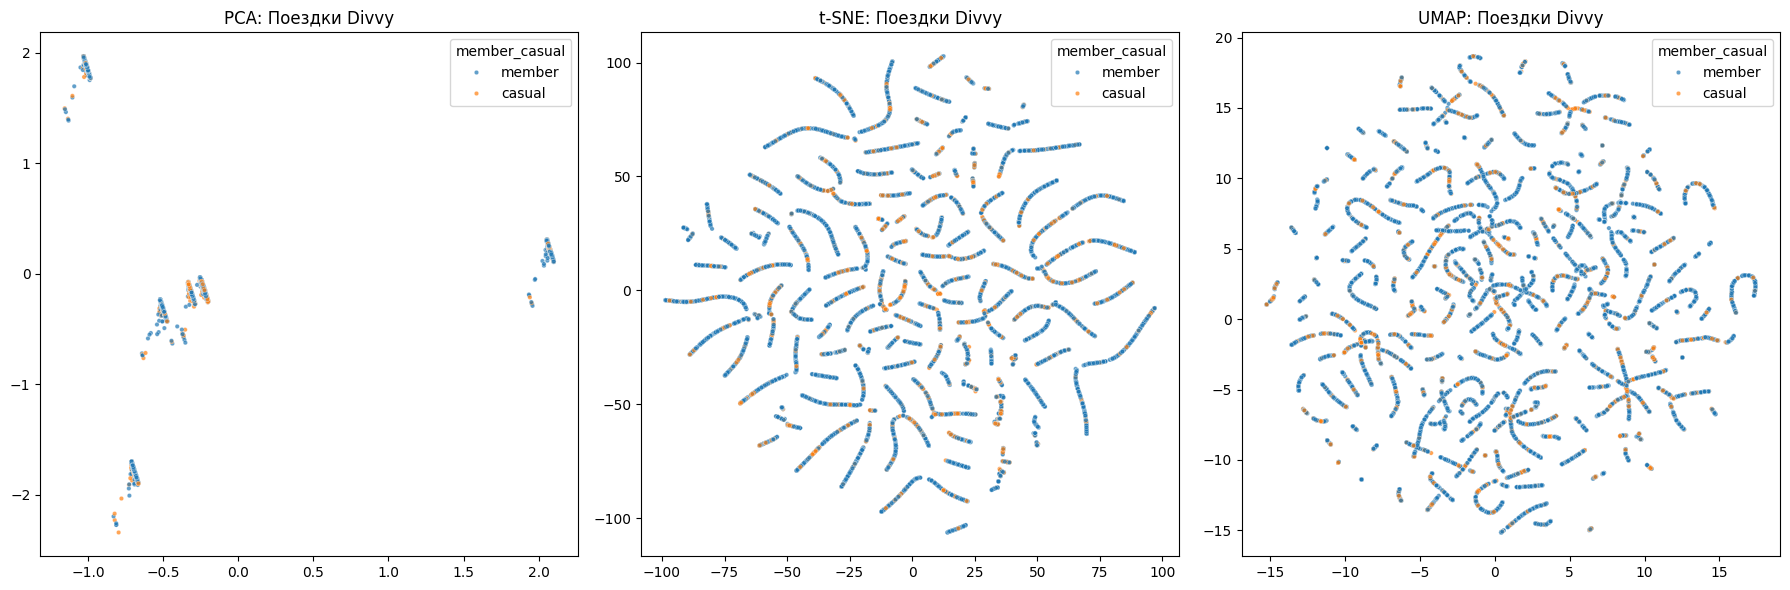

In [ ]:
# t-SNE
tsne = TSNE(n_components=2,
    perplexity=30,
    learning_rate='auto',
    early_exaggeration=12,
    metric="euclidean",
    n_jobs=n_jobs,
    random_state=42,
    verbose=False)
X_tsne = tsne.fit(X_scaled)

# UMAP
reducer = UMAP(n_components=2, n_neighbors=15, metric='euclidean', n_jobs=n_jobs)
embedding = reducer.fit_transform(X_scaled)

# Визуализация
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['member_casual'], ax=axes[0], alpha=0.7, s=10)
axes[0].set_title('PCA: Поездки Divvy')

sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=df['member_casual'], ax=axes[1], alpha=0.7, s=10)
axes[1].set_title('t-SNE: Поездки Divvy')

sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=df['member_casual'], ax=axes[2], alpha=0.7, s=10)
axes[2].set_title('UMAP: Поездки Divvy')

plt.tight_layout()
plt.show()

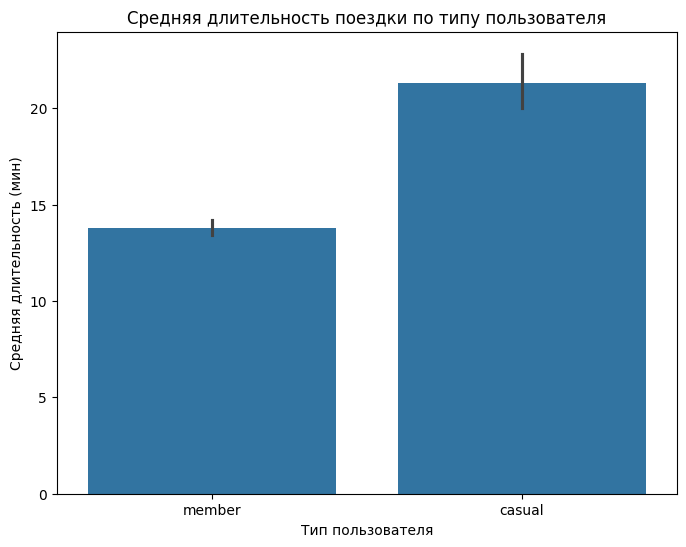

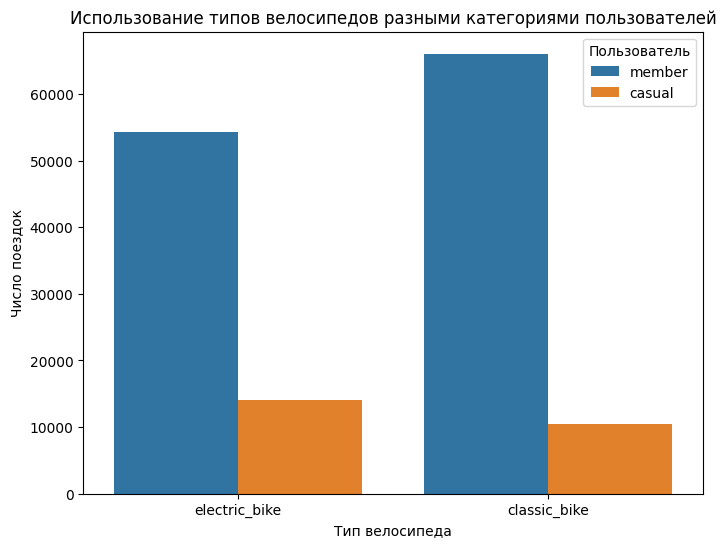

In [20]:
plt.figure(figsize=(8,6))
sns.barplot(data=df, x='member_casual', y='duration', estimator='mean')
plt.title('Средняя длительность поездки по типу пользователя')
plt.xlabel('Тип пользователя')
plt.ylabel('Средняя длительность (мин)')
plt.show()

plt.figure(figsize=(8,6))
sns.countplot(data=df, x='rideable_type', hue='member_casual')
plt.title('Использование типов велосипедов разными категориями пользователей')
plt.xlabel('Тип велосипеда')
plt.ylabel('Число поездок')
plt.legend(title='Пользователь')
plt.show()

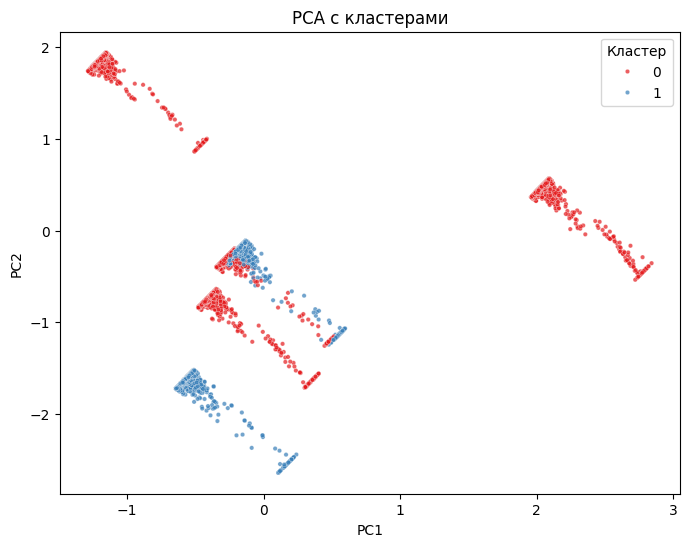

In [26]:
kmeans = KMeans(n_clusters=2, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['cluster'], palette='Set1', alpha=0.7, s=10)
plt.title('PCA с кластерами')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Кластер')
plt.show()